<a href="https://colab.research.google.com/github/Voyageran/StartNN/blob/main/linear_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.insert(0,"/content/content/notebooks/colabInstallPackage")

!cp -av '/content/gdrive/MyDrive/Colab Notebooks/d2l' '/content/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
'/content/gdrive/MyDrive/Colab Notebooks/d2l/paddle.py' -> '/content/d2l/paddle.py'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/mxnet.py' -> '/content/d2l/mxnet.py'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/tensorflow.py' -> '/content/d2l/tensorflow.py'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/torch.py' -> '/content/d2l/torch.py'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/__init__.py' -> '/content/d2l/__init__.py'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/__pycache__/mxnet.cpython-310.pyc' -> '/content/d2l/__pycache__/mxnet.cpython-310.pyc'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/__pycache__/__init__.cpython-310.pyc' -> '/content/d2l/__pycache__/__init__.cpython-310.pyc'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/__pycache__/torch.cpython-310.pyc' -> '/content/d2l/__pycache__/torch.cpython-310.pyc'
'/content/gdrive/MyDrive/Colab Notebook

# **线性神经网络**

## **线性回归**

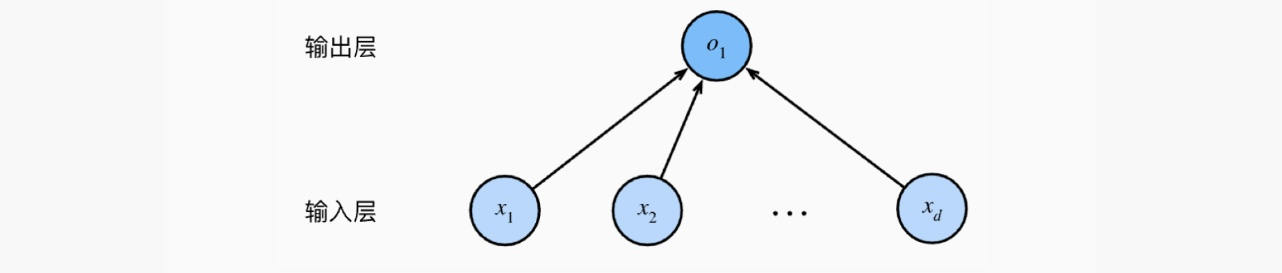

### **从零开始实现**

In [8]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

Set $\mathbf{w} = [2, -3.4]^{T}$, $b = 4.2$, noise term $ϵ$,

构造数据集
$$
 \mathbf{y} = \mathbf{X}\mathbf{w} + b + ϵ
$$

In [9]:
def synthetic_data(w,b,num_examples):
  """ generate y = Xw + b + eps"""
  X = torch.normal(0,1,(num_examples, len(w)))
  y = torch.matmul(X,w) + b #broadcast,
  # torch.matmul():If the first argument is 2-dimensional and the second argument is 1-dimensional, the matrix-vector product is returned
  y += torch.normal(0, 0.01, y.shape)
  return X, y.reshape((-1,1)) #转成列向量，因为前面计算会自动变成行向量
  #reshape中-1代表n，所以如果换成(1,-1)就是行向量

In [10]:
import torch
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [14]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([ 0.9296, -0.7406]) 
label: tensor([8.5821])


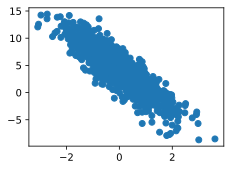

In [13]:
d2l.set_figsize()
# feature 2 and y
d2l.plt.scatter(features[:,1].detach().numpy(), #先detach移出计算图，才能变numpy
                labels.detach().numpy())


2D没意思，看下3D哈。

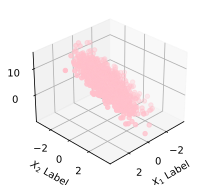

In [46]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize = (6,3))
ax = fig.add_subplot(projection='3d')

ax.scatter(features[:,0], features[:,1], labels, c ='pink')

ax.set_xlabel('$X_1$ Label')
ax.set_ylabel('$X_2$ Label')
ax.set_zlabel('Labels')

ax.view_init(elev=30,azim = 45) #elev设定仰角，azim左右动
plt.show()

**Model**

In [56]:
def linreg(X, w, b):
  """linear regression"""
  return torch.matmul(X, w) + b

In [57]:
# Initialize model parameters
w = torch.normal(0, 0.01, size = (2,1), requires_grad = True)
b = torch.zeros(1, requires_grad=True)

**Loss Function**

In [58]:
def squared_loss(y_hat, y): #没有算均值呢，所以后面除以总数放在了优化算法func里
  """l_i = 1/2 (yhat_i-y_i)^2"""
  return (y.reshape(y_hat.shape) - y_hat)**2 / 2 #reshape()来防止行列向量的不一致

**Optimization Algorthim**

显然，用最小二乘得到的线性回归最优weight是$\mathbf{w}^{\ast} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$，但是不是所有的问题都有解析解。我们现在用优化算法来解这个最优值。

我们用小批量随机梯度下降Mini-Batch Stochastic Gradient Descent (MBSGD)来minimize loss function to 优化parameters。


1.   定义一个Mini-Batch generator
2.   定义一个MBSGD函数



Let parameters $\mathbf{w} = \{ w_{j} \}_{j=1}^{J}$, $\mathbf{x}, \mathbf{w} \in \mathbb{R}^{d}$, $\alpha$ is step/learning rate, $L(\mathbf{w},b)$ is the corresponding loss function.

For each sample, regression function is
$$
\hat{y} = \mathbf{w}^{T}\mathbf{x} + b
$$

For sample $i$, the loss function we used is
$$
l^{(i)}(\mathbf{w},b) = \frac{1}{2} (\hat{y}^{(i)} - y^{(i)})^2
$$
Then, the loss function of $n$ samples in the training set is (mean square loss function)
$$
L(\mathbf{w},b) = \frac{1}{n} \sum_{i=1}^{n} \frac{1}{2}(\hat{y}^{(i)} - y^{(i)})^2 = \frac{1}{2n} \sum_{i=1}^{m} (\mathbf{w}^{T}\mathbf{x} + b - y^{(i)})^2
$$

Our goal:
$$
\mathbf{w}^{\ast}, b^{\ast} = argmin_{\mathbf{w}, b}  L(\mathbf{w}, b)
$$

The iteration equation is
$$
w_{j} := w_{j} - \alpha \frac{∂ L(\mathbf{w})}{∂ w_{j}}
$$

求个偏导，
\begin{equation}
  \begin{aligned}
    \frac{∂ L(\mathbf{w})}{∂ w_{j}} &= \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)}) (\frac{}{\partial w_j})
  \end{aligned}
\end{equation}

In [59]:
# input:批量大小、特征矩阵和标签向量，generate: batch_size的小批量
def data_iter(batch_size, features, labels):
  num_examples = len(features) #sample个数
  indices = list(range(num_examples)) # Remember to add list()
  random.shuffle(indices) #为了都抽得到
  for i in range(0, num_examples, batch_size):
    batch_indices = torch.tensor(
        indices[i: min(i+batch_size, num_examples)] # 取min是为了防止溢出，最后一个batch没取满无大碍
    )
    yield features[batch_indices], labels[batch_indices]

In [61]:
# test data_iter()
batch_size = 10

# for X, y in data_iter(batch_size, features, labels):
#   print(X, '\n', y)

Remark:
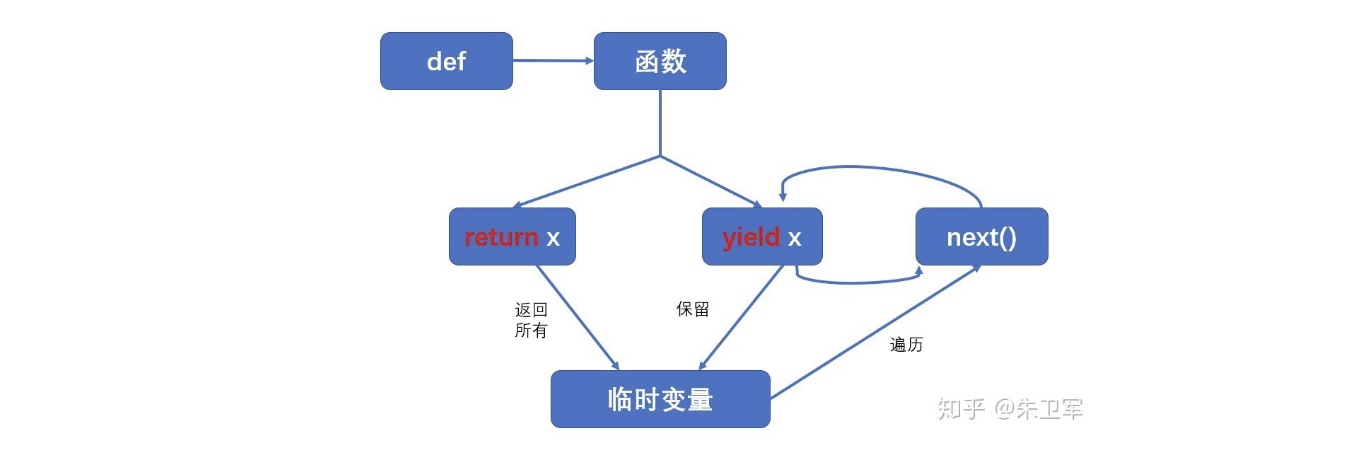

In [ ]:
#e.g.,
def fab(max):
  n, a, b = 0, 0, 1
  while n < max:
    yield b
    a, b = b, a+b
    n += 1

for n in fab(5):
    print(n)

`lr` == learning rate (deep learning) == step (optimization)

In [62]:
# Define SGD
def sgd(params, lr, batch_size):
  """Mini-batch SGD"""
  with torch.no_grad(): #更新的时候不参与梯度计算
    for param in params:
      param -= lr * param.grad / batch_size # /batch_size是因为前面loss func没有除以总个数
      param.grad.zero_()  #注意梯度清零


我们是求$argmin_{\boldsymbol{\theta}} L(\boldsymbol{\theta})$，所以

## **SoftMax**